# PROJECTION OF THE RISK FREE CURVE AND RECALIBRATION_v2

The purpose of this workbook is to showcase the calibration methodology inside OSEM. The key to the calibration is the Smith Wilson algorithm commonly used in insurance. This algorithm allows a continuous approximation of arbitrary maturities based on a subset of available maturities. This example is split onto 3 parts. 

 - The first part shows how the necessary parameters and curves are imported from input files. 
 - Second part shows how the curves are generated and the Smith-Wilson calibrations derived. 
 - The last part shows how the saved calibration can be used to derive an the discount rates for any maturity.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [5]:
from ImportData import import_SWEiopa
from CurvesClass import Curves

## Importing files

The parameters and the current risk free curve are provided as input:

 - Parameters.csv; Parameters related to the run 
 - EIOPA_param_file.csv; Assumed yield curve at modelling date and relevant maturities
 - EIOPA_curves_file.csv; Parameters related to the EIOPA time 0 calibration
 
 
 The exact location of the EIOPA files is encoded in the Parameters input file. 

In [8]:
paramfile = pd.read_csv("Input\Parameters.csv", index_col="Parameter")

The location of the two EIOPA files are:

In [10]:
selected_param_file = paramfile["Value"].loc["EIOPA_param_file"]
selected_curves_file = paramfile["Value"].loc["EIOPA_curves_file"]

The risk free curve belongs to the following country:

In [12]:
country = paramfile["Value"].loc["country"]

Import all necessary parameters:

In [14]:
[maturities_country, curve_country, extra_param, Qb] = import_SWEiopa(selected_param_file, selected_curves_file, country)

## Preparation and treatment of the curves

The OSEM does multiple steps in order to make it easier for OSEM to access discount curves at any point in time and for arbitrary maturities. All steps are performed and saved within the Curves class.

### The curves class

The curve class object contains all the data necessary to run the model.

In [19]:
# ultimate forward rate
ufr = extra_param["UFR"]/100

# Numeric precision of the optimisation
precision = float(paramfile["Value"].loc["Precision"])

# Targeted distance between the extrapolated curve and the ultimate forward rate at the convergence point
tau = float(paramfile["Value"].loc["Tau"])# 1 basis point

modelling_date = paramfile.loc["Modelling_Date"]

# Number of projection years
n_years = int(paramfile.loc["n_proj_years"].values[0])

In [20]:
curves = Curves(ufr, precision, tau, modelling_date, country)

After the Curves class is initiated, there are a series if calibrations that needs to be performed.

 - Saving of the input term structure
 - Calculation of the forward rates
 - Projection of the forward spot rates
 - Calculation of the Smith-Wilson calibrations for each period

### Save the input term structure

SetObservedTermStructure sets the liquid maturities and the corresponding yields to the m_obs and r_obs property of the Curves class. 

In [23]:
curves.SetObservedTermStructure(maturity_vec=curve_country.index.tolist(), yield_vec=curve_country.values)

### Calculate 1 year forward rates

Using the time 0 spot curve provided as input, the yearly forward rates can be calculated from the annually reported yield curve
$$
fw_{EIOPA,1} = y_1
$$

otherwise:

$$
fw_{EIOPA,i} = \frac{(1 + y_i)^{-i}}{(1 + y_{i-1})^{-(i-1)}} 
$$

Note that this implementation assumes that all forward rates are exactly 1 year apart as provided by EIOPA.

Where:

 - $i$ is the year (Ex. 1,2,3, $\dots$)
 - $y_i$ is the yield for the year $i$
 - $fw_{EIOPA,i}$ is the 1-year forward rate between years $i-1$ and $i$

In [26]:
curves.CalcFwdRates()

### Forward yield curve

The forward yield curve can be calculated by using the 1-year forward rates from the suitable moment onwards. The spot yield curve is calculated for each projection period. For the projection period $i$, the yield curve can be calculated as:

$$
y^j_{i-j} = \prod_{k=j}^i\big(1+fw_{EIOPA}(k)\big)^{-(k-j)}
$$

Where:
 - $j$ is the modelling period at which the model is performing the calculations 
 - $i-j$ is the time period within the modelling period
 - $y^j_{k}$ is the yield $k$ years after the modelling period $j$

In [30]:
curves.ProjectForwardRate(n_years)

## Calibrate Smith-Wilson on each yield curve

Each forward yield curve is used to calibrate the SW algorithm. This calibration can then be used to generate yield corves of arbitrary maturities. The calibration is split on two parts. First one calibrates the curve at time 0.

### Calibration of the interpolation/extrapolation algorithm

Both at time 0 and in following projection years, the same calibration algorithm is performed. The algorithm looks to minimize the difference between the xxx and the ultimate forward rate as recommended by EIOPA:


$$
T = \max(U+40,60)
$$

$$
g(\alpha) = |f(T) - \omega| = \frac{\alpha}{|1-\kappa e^{\alpha T}|}
$$

The calibration consists of using a bisection algorithm to minimize the difference between the ultimate forward rate $\omega$.

The calibration is:

$$
\min \alpha 
$$

subject to constraints:

$$
\alpha \geq \alpha_{min}
$$
and

$$
g(\alpha) \leq \tau
$$

 And $\kappa$ is defined as:

 $$
\kappa = \frac{1 + \alpha u^T Qb}{sinh(\alpha u^T)Qb}
 $$ 

 $$
Q = d I C
 $$

$$
d = e^{-\omega u}
$$



Where:
 - $\alpha$ is the free parameter to be calibrated
 - $\alpha_{min}$ is the lower bound of the allowable values
 - $U$ is the last liquid point
 - $g(\alpha)$ is the extrapolated
 - $C$ is a matrix of cash flows

In [35]:
curves.CalibrateProjected(n_years, 0.05, 0.5, 1000)

### Spread treatment

ToDo

## Example 1

One of the properties of the Smith-Wilson algorithm is that it retains the curve values at the liquid points provided in the calibration. This property is tested in the first example. A projection year is selected and the algorithm is asked to provide the values using the calibration vector. The original yield curve that was used to calibrate is then compared to the output.

In [39]:
spread = 0.00

In [40]:
p_year = 6

In [41]:
interpolated_curve = curves.RetrieveRates(p_year, curves.m_obs["Maturities_year_"+str(p_year)].values[:-p_year], "Yield",spread=spread)

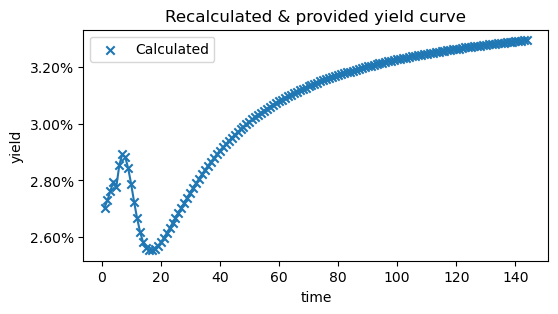

In [42]:
fig, ax1 = plt.subplots(1, 1)
ax1.scatter(curves.m_obs["Maturities_year_"+str(p_year)].values[:-p_year], interpolated_curve*100, label="Calculated", marker="x")
ax1.plot(curves.m_obs["Maturities_year_"+str(p_year)].values[:-p_year], curves.r_obs["Yield_year_"+str(p_year)].values[:-p_year]*100)
ax1.set_ylabel("yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

## Example 2

The calibration will be used to provide OSAM with yields for arbitrary maturities. This example verifies if the calibration provides yields for maturities not provided as input into the calibration.
Assuming the algorithm is processing the year 3. A hypothetical asset has a cash flow at year fractions:

$$ \{0.7, 1.2, 2.1, 3.543\} $$

To make it possible to calculate the present value, the corresponding discount rates are calculated:


With the calibrated vector $b$, the required yields can easily be obtained by applying the formula:

$$
p(v) = e^{-\omega v} \big(1 + H(v,u) b \big)
$$

Where:
 - $v$ is the vector of desired maturities
 - $ \omega $ is the ultimate forward intensity
 - $u$ is the vector of maturities that were used in the calibration
 - $H(v,u)$ is the Heart of the Wilson function
 - $b$ is the calibration vector


In [46]:
desired_mat = np.array([0.7, 1.2, 1.3543])

### Yield calculation


The yield in each modelling period can be interpolated/extrapolated using the Smith-Wilson calibration vector calculated above. This allows OSEM to apply continuous yields.

In [48]:
spread = 0.0

In [49]:
display(curves.RetrieveRates(3, desired_mat, "Yield",spread))

,Yield
0,0.026187
1,0.026155
2,0.026145


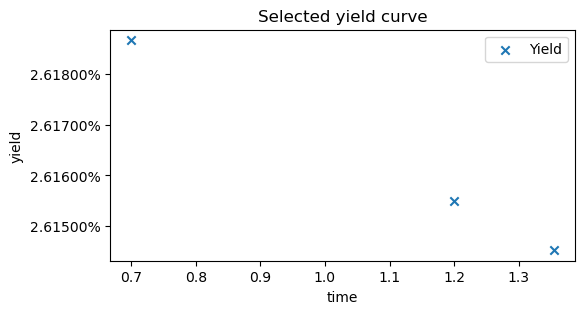

In [50]:
fig, ax1 = plt.subplots(1, 1)
ax1.scatter(desired_mat, curves.RetrieveRates(3, desired_mat, "Yield", spread)*100, label="Yield", marker="x")
ax1.set_ylabel("yield")
ax1.set_title('Selected yield curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

### Capitalisation factor calculation


The capitalisation factor can be calculated as:

$$
c_i(t) = \big(1+ y_i(t)\big)^{t} 
$$


In [52]:
display(curves.RetrieveRates(3, desired_mat, "Capitalisation", spread))

,Capitalisation
0,1.018259
1,1.031468
2,1.035572


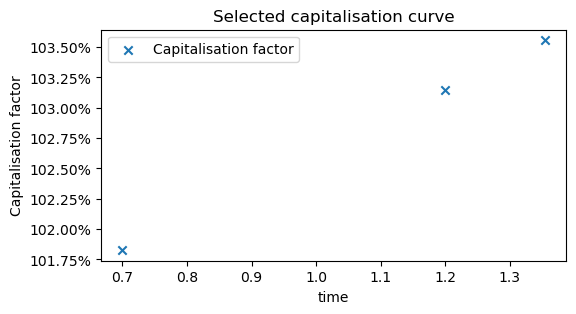

In [53]:
fig, ax1 = plt.subplots(1, 1)
ax1.scatter(desired_mat, curves.RetrieveRates(3, desired_mat, "Capitalisation", spread)*100, label="Capitalisation factor", marker="x")
ax1.set_ylabel("Capitalisation factor")
ax1.set_title('Selected capitalisation curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

### Discount factor calculation

The discount factors can be calculated from the yield:

$$
d_i(t) = \big(1+ y_i(t)\big)^{-t} 
$$

Where:
 - $t$ is time increment from the modelling period (Ex. 1.5 is 1 year and 6 months after the modelling period
 - $y_i(t)$ is the annualized yield for maturity t after the modelling period $i$
 - $c_i(t)$ is the capitalisation factor for 1 unit, until $t$ years after the modelling period $i$

 - $d_i(t)$ is the discount factor for a cash flow of value 1, occurring $t$ years after the modelling period $i$, discounted to the modelling period $i$


In [56]:
display(curves.RetrieveRates(3, desired_mat, "Discount", spread))

,Discount
0,0.982068
1,0.969492
2,0.965650


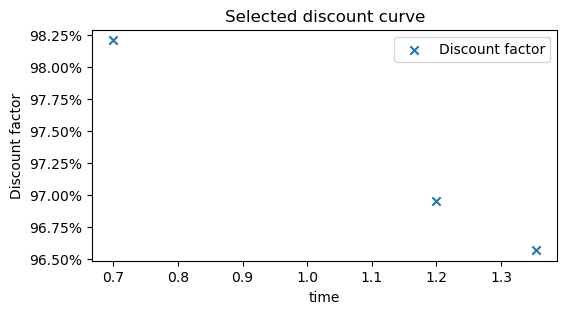

In [57]:
fig, ax1 = plt.subplots(1, 1)
ax1.scatter(desired_mat, curves.RetrieveRates(3, desired_mat, "Discount", spread)*100, label="Discount factor", marker="x")
ax1.set_ylabel("Discount factor")
ax1.set_title('Selected discount curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()